# **Exploratory Data Analysis**
---

- Goal: understand distributions, class balance, and potential text‑based features that will inform feature‑engineering and model selection for M4.

## Notebook Outline 
1. [Data & Imports](#1-data--imports)  
2. [Class Balance](#2-class-balance)  
3. [Tweet-Length Distributions](#3-tweet-length-distributions)  
4. [Negative-Reason Breakdown](#4-negative-reason-breakdown)  
5. [Sentiment by Airline](#5-sentiment-by-airline)  
6. [Quick TF-IDF Peek — Top Terms by Sentiment](#6-quick-tf-idf-peek--top-terms-by-sentiment)  
7. [Key Insights](#7-key-insights)

# 1. Data & Imports  
***
Load the pre‑processed dataset **`data/processed/tweets.parquet`** and perform a quick shape / null check.

* **14 640 rows × 5 columns** after preprocessing — matches raw count (no data loss).  
* Columns: `tweet_id`, `airline`, `airline_sentiment`, `clean_text`, `negativereason`  
* *No unexpected nulls* (aside from `negativereason`, which is naturally sparse).

In [ ]:
# Imports 
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer

PROJ_ROOT  = Path.cwd().parent              
FIG_DIR    = PROJ_ROOT / "reports" / "figs_eda"
DATA_PATH  = PROJ_ROOT / "data" / "processed" / "tweets.parquet"

FIG_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(DATA_PATH)

print(f"Loaded {len(df):,} rows × {df.shape[1]} columns")
display(df.head())

Loaded 14,640 rows × 5 columns


,tweet_id,airline,airline_sentiment,clean_text,negativereason
0,570306133677760513,Virgin America,neutral,what said.,None
1,570301130888122368,Virgin America,positive,plus you've added commercials to the experienc...,None
2,570301083672813571,Virgin America,neutral,i didn't today... must mean i need to take ano...,None
3,570301031407624196,Virgin America,negative,"it's really aggressive to blast obnoxious ""ent...",Bad Flight
4,570300817074462722,Virgin America,negative,and it's a really big bad thing about it,Can't Tell


# 2. Class Balance  
***
The dataset is **strongly imbalanced** – negative tweets dominate.

| Sentiment | Share |
|-----------|-------|
| **Negative** | **63 %** |
| Neutral     | 21 % |
| Positive    | 16 % |

* **Implication →** apply stratified sampling and class weighting / resampling for any supervised model.

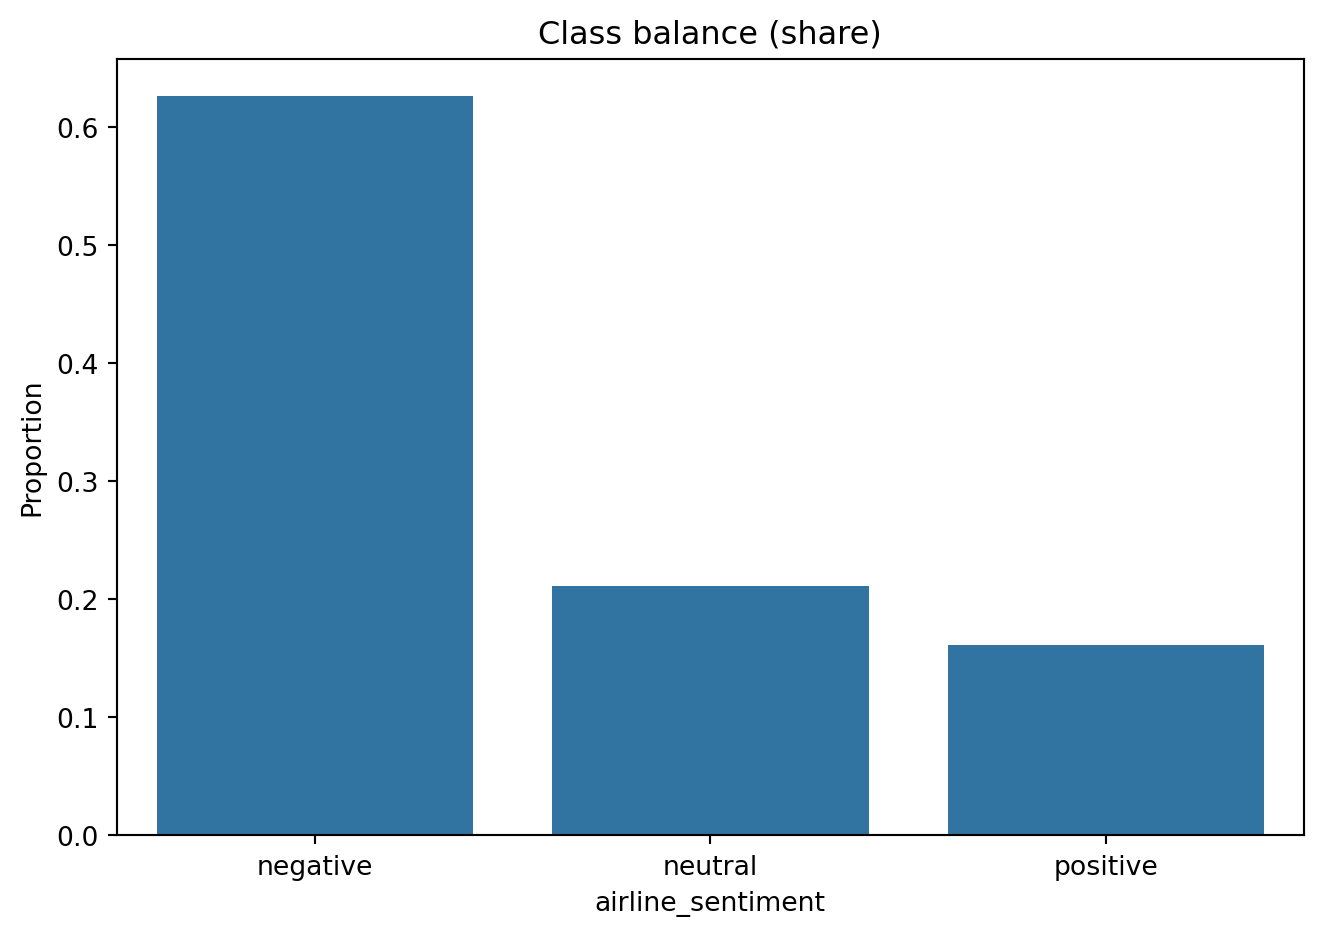

In [2]:
sent_dist = df["airline_sentiment"].value_counts(normalize=True)
sns.barplot(x=sent_dist.index, y=sent_dist.values)
plt.title("Class balance (share)")
plt.ylabel("Proportion")
plt.tight_layout()
plt.savefig("../reports/figs_eda/class_balance.png", dpi=150)

# 3. Tweet‑Length Distributions  
***
Two views of tweet length after cleaning.

| Metric | Median | IQR | 95th pct |
|--------|--------|-----|-----------|
| Characters | **108** | 74 – 129 | 167 |
| Words      | **17**  | 11 – 22  | 29 |

* Character distribution is left‑skewed but bounded < 180; word counts top out near 35.  
* **Padding/truncation guideline →** 160 chars *or* 30 words captures > 99 % of tweets.

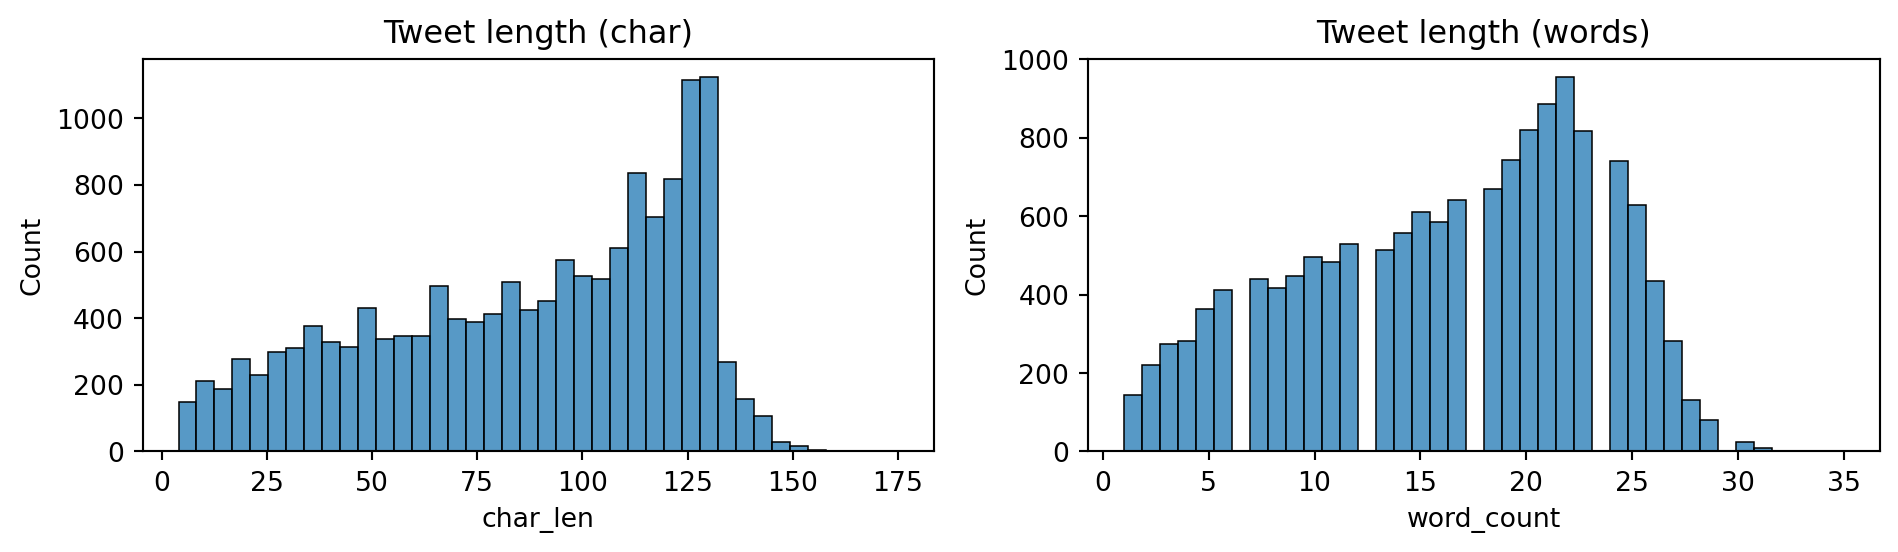

In [3]:
df["char_len"]  = df["clean_text"].str.len()
df["word_count"] = df["clean_text"].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(df["char_len"], ax=axes[0], bins=40)
axes[0].set_title("Tweet length (char)")
sns.histplot(df["word_count"], ax=axes[1], bins=40)
axes[1].set_title("Tweet length (words)")
plt.tight_layout()
plt.savefig("../reports/figs_eda/length_distributions.png", dpi=150)

# 4. Negative‑Reason Breakdown 
***
Top complaint categories among **negative** tweets.

| Rank | Reason                     | Count | Share |
|------|----------------------------|-------|-------|
| 1 | Customer Service Issue        | ~3 000 | 33 % |
| 2 | Late Flight                  | ~1 600 | 18 % |
| 3 | Can’t Tell / N/A              | ~1 300 | 13 % |
| 4 | Cancelled Flight             | ~1 000 | 11 % |
| 5 | Lost Luggage                 |   800 |  9 % |

* **Customer‑service** complaints dominate—consider a dedicated topic model or sentiment sub‑label.  
* Tail reasons (< 3 %) can be merged or dropped to prevent feature sparsity.

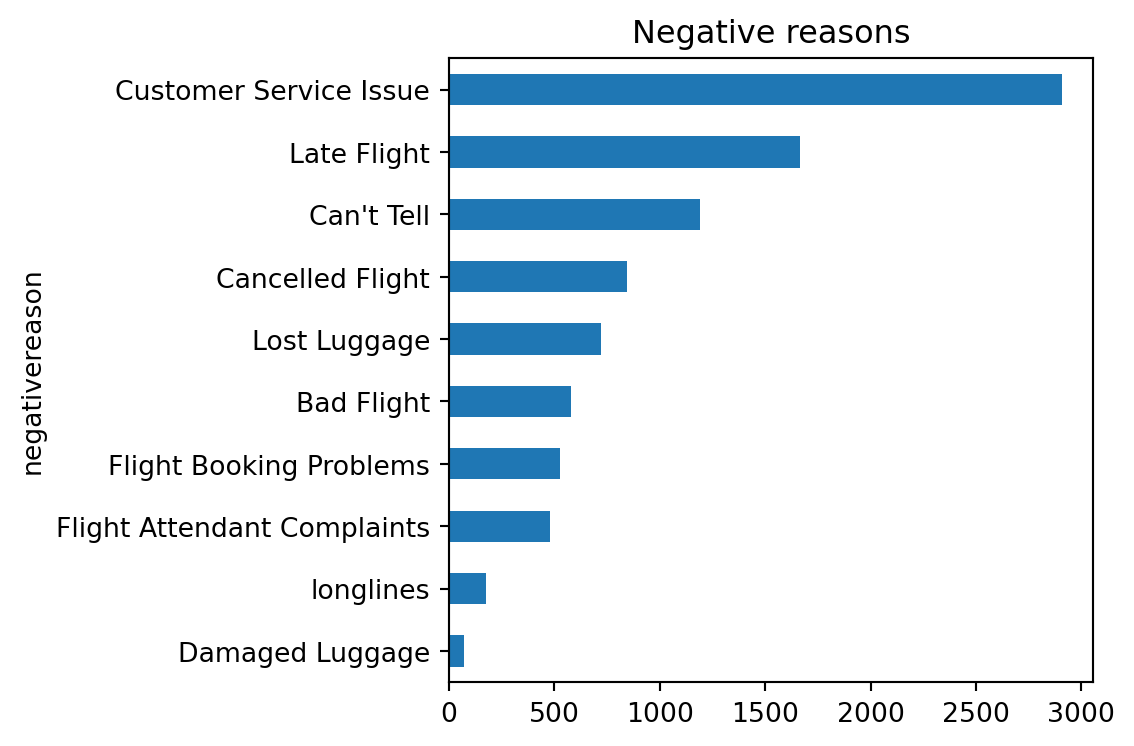

In [4]:
neg_counts = (df[df["airline_sentiment"] == "negative"]
              .value_counts("negativereason")
              .sort_values())
neg_counts.plot(kind="barh", figsize=(6,4))
plt.title("Negative reasons")
plt.tight_layout()
plt.savefig("../reports/figs_eda/negative_reasons.png", dpi=150)

# 5. Sentiment by Airline  
***
Two complementary views:

* **Stacked 100 % bar** → distribution of sentiments per airline.  
* **Diverging bar** → **Positive % − Negative %** (“net gap”).

| Airline | Net gap | Insight |
|---------|---------|---------|
| US Airways | **‑0.66** | Most negative overall |
| American   | ‑0.55     | Similar to US Airways |
| United     | ‑0.50     | High negative volume |
| Southwest  | ‑0.23     | Moderately better perception |
| Delta      | ‑0.17     | Best among majors |
| Virgin America | **‑0.03** | Nearly sentiment‑neutral |

* **Virgin America** enjoys the **highest positive share (~ 34 %)**.  
* Consider adding `airline` as a categorical feature or training airline‑specific models.

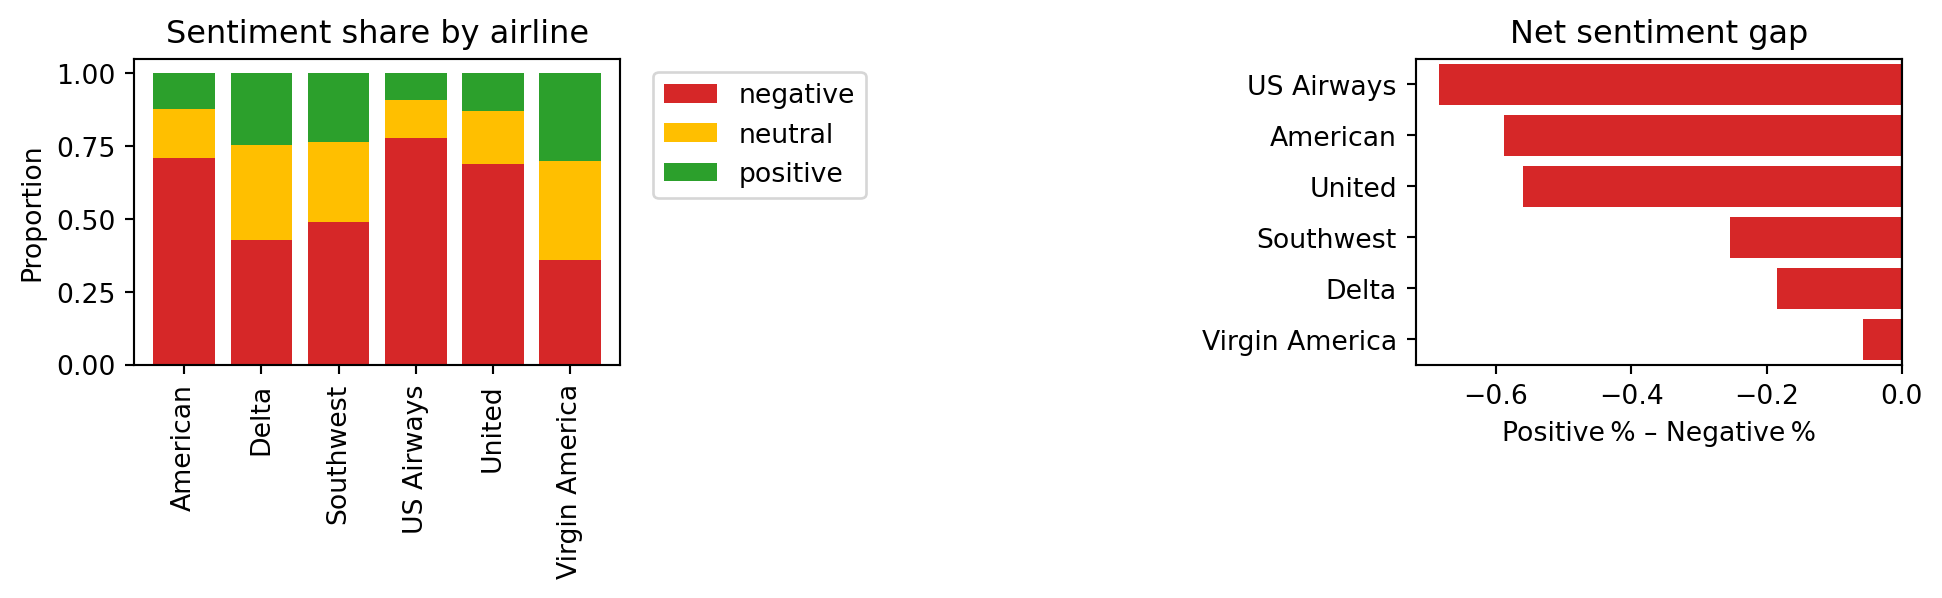

<Figure size 384x288 with 0 Axes>

In [ ]:
# prepare data
sent_prop = (
    df.pivot_table(index="airline",
                   columns="airline_sentiment",
                   values="tweet_id",
                   aggfunc="count",
                   fill_value=0)
      .pipe(lambda t: t.div(t.sum(axis=1), axis=0))               # row %
      [["negative", "neutral", "positive"]]                       # order
)
gap = (sent_prop["positive"] - sent_prop["negative"]).sort_values()

# plot combined figure 
palette = ["#d62728", "#ffbf00", "#2ca02c"]

fig, axes = plt.subplots(
    1, 2, figsize=(10, 3), gridspec_kw={"wspace": 0.35}, constrained_layout=True
)

# left: stacked 100 %
sent_prop.plot(kind="bar", stacked=True, width=0.8,
               color=palette, ax=axes[0])
axes[0].set_ylabel("Proportion")
axes[0].set_xlabel("")
axes[0].set_title("Sentiment share by airline")
axes[0].legend(title="", loc="upper left", bbox_to_anchor=(1.04, 1))

# right: diverging bar
sns.barplot(x=gap.values, y=gap.index, ax=axes[1])
for bar, v in zip(axes[1].patches, gap.values):
    bar.set_facecolor("#d62728" if v < 0 else "#2ca02c")
axes[1].set_xlabel("Positive % – Negative %")
axes[1].set_ylabel("")
axes[1].axvline(0, color="k", lw=0.8)
axes[1].set_title("Net sentiment gap")

display(fig)
plt.close(fig) 

fig.savefig(FIG_DIR / "sentiment_share_and_gap.png", dpi=150)

# individual images
for name, f in [("sentiment_share_by_airline.png", sent_prop),
                ("net_sentiment_gap.png", gap)]:
    plt.figure(figsize=(4,3))
    if name.startswith("sentiment"):
        f.plot(kind="bar", stacked=True, width=0.8, color=palette, legend=False)
    else:
        sns.barplot(x=f.values, y=f.index)
        for bar, v in zip(plt.gca().patches, f.values):
            bar.set_facecolor("#d62728" if v < 0 else "#2ca02c")
        plt.axvline(0, color="k", lw=0.8)
    plt.tight_layout()
    plt.savefig(FIG_DIR / name, dpi=150)
    plt.close()

# 6. Quick TF‑IDF Peek — Top Terms by Sentiment  
***

| Negative | Neutral | Positive |
|----------|---------|----------|
| flight | flight | thanks |
| cancelled | thanks | thank |
| service | dm | flight |
| hours | fleek | great |
| customer | fleet | love |

* Negative tweets emphasise disruption words **“cancelled”, “service”, “hours”**.  
* Positive tweets dominated by gratitude **“thanks”, “love”, “great”**.  
* Confirms that the cleaning pipeline retained sentiment‑bearing tokens and removed noise.

In [ ]:
# build separate corpora per sentiment
corpora = {
    sentiment: df.loc[df["airline_sentiment"] == sentiment, "clean_text"].tolist()
    for sentiment in ["negative", "neutral", "positive"]
}

# fit TF-IDF and grab top 10 terms for each 
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5_000,
    ngram_range=(1, 2),
)

top_terms = {}
for sentiment, texts in corpora.items():
    tfidf_matrix = vectorizer.fit_transform(texts)
    # average tf-idf per term & get top 10 indices
    avg_scores = tfidf_matrix.mean(axis=0).A1
    top_idx = avg_scores.argsort()[::-1][:10]
    top_terms[sentiment] = [vectorizer.get_feature_names_out()[i] for i in top_idx]

# show as a DataFrame 
top_df = pd.DataFrame(top_terms)
display(top_df)

# save to CSV
top_df.to_csv(FIG_DIR / "top_tfidf_terms.csv", index=False)

,negative,neutral,positive
0,flight,flight,thanks
1,cancelled,thanks,thank
2,service,dm,flight
3,hours,fleek,great
4,customer,fleet,just
5,just,fleet fleek,love
6,hold,just,service
7,help,flights,best
8,time,help,good
9,plane,need,awesome


# 7. Key Insights  
***
* **Label imbalance** (63 % negative) demands stratified splits and weighting.  
* **Typical tweet length** ≈ 110 chars / 17 words → standard tokenizer window is sufficient.  
* **Customer‑service** and **late‑flight** issues form > 50 % of negative reasons.  
* **Virgin America** and **Southwest** exhibit more positive sentiment → airline feature likely informative.  

## Next Steps  
1. Finalise feature list — text (TF‑IDF / embeddings) + metadata (`airline`, time, etc.).  
2. Select resampling or class‑weight strategy for modelling.  
3. Prototype baseline models in **`04_baseline_model.ipynb`** 